<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [1]:
import re
import os
import gdown
import json
import logging
from pathlib import Path
from io import StringIO
import pickle


import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences, plot_model, to_categorical
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Dense, Flatten, LSTM, SimpleRNN, Embedding, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [2]:
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 19.4MB/s]


In [3]:
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)

Visualizando el archivo json

In [4]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [8]:
from rich.pretty import pprint

In [9]:
pprint(data[:2])

[
│   {
│   │   'dialog': [
│   │   │   {
│   │   │   │   'id': 0,
│   │   │   │   'sender': 'participant1',
│   │   │   │   'text': 'hi there',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Human'
│   │   │   }
│   │   ],
│   │   'start_time': '2018-10-29 03:32:08.296000',
│   │   'end_time': '2018-10-29 03:32:08.296000',
│   │   'bot_profile': [
│   │   │   'i like to talk but people have a hard time understanding.',
│   │   │   'i like to look at blocks and sing about letters.',
│   │   │   'i like to eat chocolate candy.',
│   │   │   'when i grow up i want to be a dog.'
│   │   ],
│   │   'user_profile': [
│   │   │   'i am a clean eater.',
│   │   │   'my parents were both very athletic.',
│   │   │   'i love running and preparing for marathons.',
│   │   │   'i am a cancer survivor.'
│   │   ],
│   │   'eval_score': None,
│   │   'profile_match': '',
│   │   'participant1_id': {'class': 'User', 'user_id': 'User 00172'},
│   │   'participant2_id': {'class': 'Bot', 'user_id': 'Bot 004'}
│   },
│   {
│   │   'dialog': [
│   │   │   {
│   │   │   │   'id': 0,
│   │   │   │   'sender': 'participant1',
│   │   │   │   'text': 'Hello!',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Human'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 1,
│   │   │   │   'sender': 'participant2',
│   │   │   │   'text': 'Hi! How are you?',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Bot'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 2,
│   │   │   │   'sender': 'participant1',
│   │   │   │   'text': 'Not bad! And You?',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Human'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 3,
│   │   │   │   'sender': 'participant2',
│   │   │   │   'text': "I'm doing well. Just got engaged to my high school sweetheart.",
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Bot'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 4,
│   │   │   │   'sender': 'participant1',
│   │   │   │   'text': 'Wowowowow! Congratulations! Is she pretty?',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Human'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 5,
│   │   │   │   'sender': 'participant2',
│   │   │   │   'text': "She 's pretty cute. She invited me to dinner tonight. 🙂",
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Bot'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 6,
│   │   │   │   'sender': 'participant1',
│   │   │   │   'text': 'Cool! Have a good time you both! And what is your hobby?',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Human'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 7,
│   │   │   │   'sender': 'participant2',
│   │   │   │   'text': 'I love music! I love Taylor swift. 😉',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Bot'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 8,
│   │   │   │   'sender': 'participant1',
│   │   │   │   'text': 'Me too. And what about Iggy Pop?',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Human'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 9,
│   │   │   │   'sender': 'participant2',
│   │   │   │   'text': 'I love Ziggy! He is my favorite. Are you and your wife millennial too?',
│   │   │   │   'evaluation_score': 1,
│   │   │   │   'sender_class': 'Bot'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 10,
│   │   │   │   'sender': 'participant1',
│   │   │   │   'text': "I have no wife. And I'm not millenial, I'm X generation.",
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Human'
│   │   │   },
│   │   │   {
│   │   │   │   'id': 11,
│   │   │   │   'sender': 'participant1',
│   │   │   │   'text': 'Hey? Where are you?',
│   │   │   │   'evaluation_score': None,
│   │   │   │   'sender_class': 'Human'
│   │   │   },
│  

In [11]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033

In [12]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento


Tamaño del vocabulario

In [13]:
MAX_VOCAB_SIZE = 8000

In [14]:
def preprocess_inputs(input_sentences, max_vocab_size=20000):
    input_tokenizer = Tokenizer(num_words=max_vocab_size)
    input_tokenizer.fit_on_texts(input_sentences)
    input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

    word2idx_inputs = input_tokenizer.word_index
    max_input_len = max(len(sen) for sen in input_integer_seq)
    encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len, padding='post')

    return word2idx_inputs, max_input_len, encoder_input_sequences, input_tokenizer


In [15]:
def preprocess_outputs(output_sentences, max_vocab_size=MAX_VOCAB_SIZE):
    output_sentences_inputs = ["<sos> " + sentence for sentence in output_sentences]
    output_sentences_targets = [sentence + " <eos>" for sentence in output_sentences]

    output_tokenizer = Tokenizer(num_words=max_vocab_size, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
    output_tokenizer.fit_on_texts(output_sentences_inputs + output_sentences_targets)

    output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
    output_target_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_targets)

    word2idx_outputs = output_tokenizer.word_index
    num_words_output = min(len(word2idx_outputs) + 1, max_vocab_size)
    max_out_len = max(len(sen) for sen in output_target_integer_seq)

    decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
    decoder_target_sequences = pad_sequences(output_target_integer_seq, maxlen=max_out_len, padding='post')

    return (word2idx_outputs, max_out_len, num_words_output,
            decoder_input_sequences, decoder_target_sequences, output_tokenizer)


In [16]:
def create_decoder_targets(decoder_target_sequences, max_out_len, num_words_output):
    decoder_targets = np.zeros((len(decoder_target_sequences), max_out_len, num_words_output), dtype='float32')

    for i, target_seq in enumerate(decoder_target_sequences):
        for t, word_idx in enumerate(target_seq):
            if word_idx > 0:
                decoder_targets[i, t, word_idx] = 1.0

    return decoder_targets

In [17]:
# Preprocesar entradas
word2idx_inputs, max_input_len, encoder_input_sequences, input_tokenizer = preprocess_inputs(input_sentences)

# Preprocesar salidas
(word2idx_outputs, max_out_len, num_words_output,
 decoder_input_sequences, decoder_target_sequences, output_tokenizer) = preprocess_outputs(output_sentences)

# Crear targets
decoder_targets = create_decoder_targets(decoder_target_sequences, max_out_len, num_words_output)


In [18]:
decoder_targets = to_categorical(decoder_target_sequences, num_classes=num_words_output)

- `word2idx_inputs`

In [25]:
subset = dict(list(word2idx_inputs.items())[:20])
subset

{'i': 1,
 'you': 2,
 'do': 3,
 'what': 4,
 'a': 5,
 'to': 6,
 'are': 7,
 'for': 8,
 'am': 9,
 'how': 10,
 'hi': 11,
 'like': 12,
 'living': 13,
 'love': 14,
 'is': 15,
 'have': 16,
 'm': 17,
 'that': 18,
 'hello': 19,
 'oh': 20}

- `word2idx_outputs`

In [26]:
subset = dict(list(word2idx_outputs.items())[:20])
subset

{'<eos>': 1,
 '<sos>': 2,
 'you': 3,
 'i': 4,
 'do': 5,
 'what': 6,
 'a': 7,
 'are': 8,
 'to': 9,
 'for': 10,
 'how': 11,
 'am': 12,
 'living': 13,
 'like': 14,
 'love': 15,
 'have': 16,
 'is': 17,
 'm': 18,
 'your': 19,
 'read': 20}

Test de IDs para `sos` y `eos`

In [ ]:
word2idx_outputs.get('<sos>')

2

In [ ]:
word2idx_outputs.get('<eos>')

1

In [29]:
decoder_targets

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

### 3 - Preparar los embeddings


Embeddings de **FastText**

In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa'
output = 'fasttext.pkl'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa
From (redirected): https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&confirm=t&uuid=e53289de-f99f-46b8-9bec-ec375d2df0ee
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:42<00:00, 67.3MB/s]


'fasttext.pkl'

In [ ]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

# Armamos clases particulares para manejar los embeddings de Glove y Fasttext
# que heredan de la clase anterior WordsEmbeddings
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
model_embeddings = FasttextEmbeddings()

In [ ]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [ ]:
embedding_matrix.shape

(1799, 300)

In [ ]:
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print(pd.DataFrame(embedding_matrix[:5, :10]))

       0       1       2       3       4      5       6       7       8      9
0 0.0000  0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000 0.0000
1 0.0030 -0.1437 -0.1699  0.0111  0.1434 0.0318 -0.5290  0.2416  0.0280 0.0559
2 0.2057 -0.5250  0.3111 -0.0047  0.1311 0.0029 -1.0216 -0.2306  0.1517 0.0873
3 0.0296 -0.3039 -0.3671 -0.1752  0.4569 0.0231 -0.4491 -0.3985 -0.2558 0.2040
4 0.1865 -0.4859 -0.2169  0.0645 -0.1432 0.0677 -0.7967 -0.1050 -0.0317 0.1169


### 4 - Modelo


In [ ]:
max_input_len

9

In [ ]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2) # recurrent_dropout=0.2
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True,
                    dropout=0.2) # recurrent_dropout=0.2
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 9, 300)    │    539,700 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 11, 128)   │    231,296 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │    219,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 11, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 11, 1807)  │    233,103 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,355,331 (5.17 MB)

 Trainable params: 815,631 (3.11 MB)

 Non-trainable params: 539,700 (2.06 MB)

**Modelo completo (encoder+decoder)**

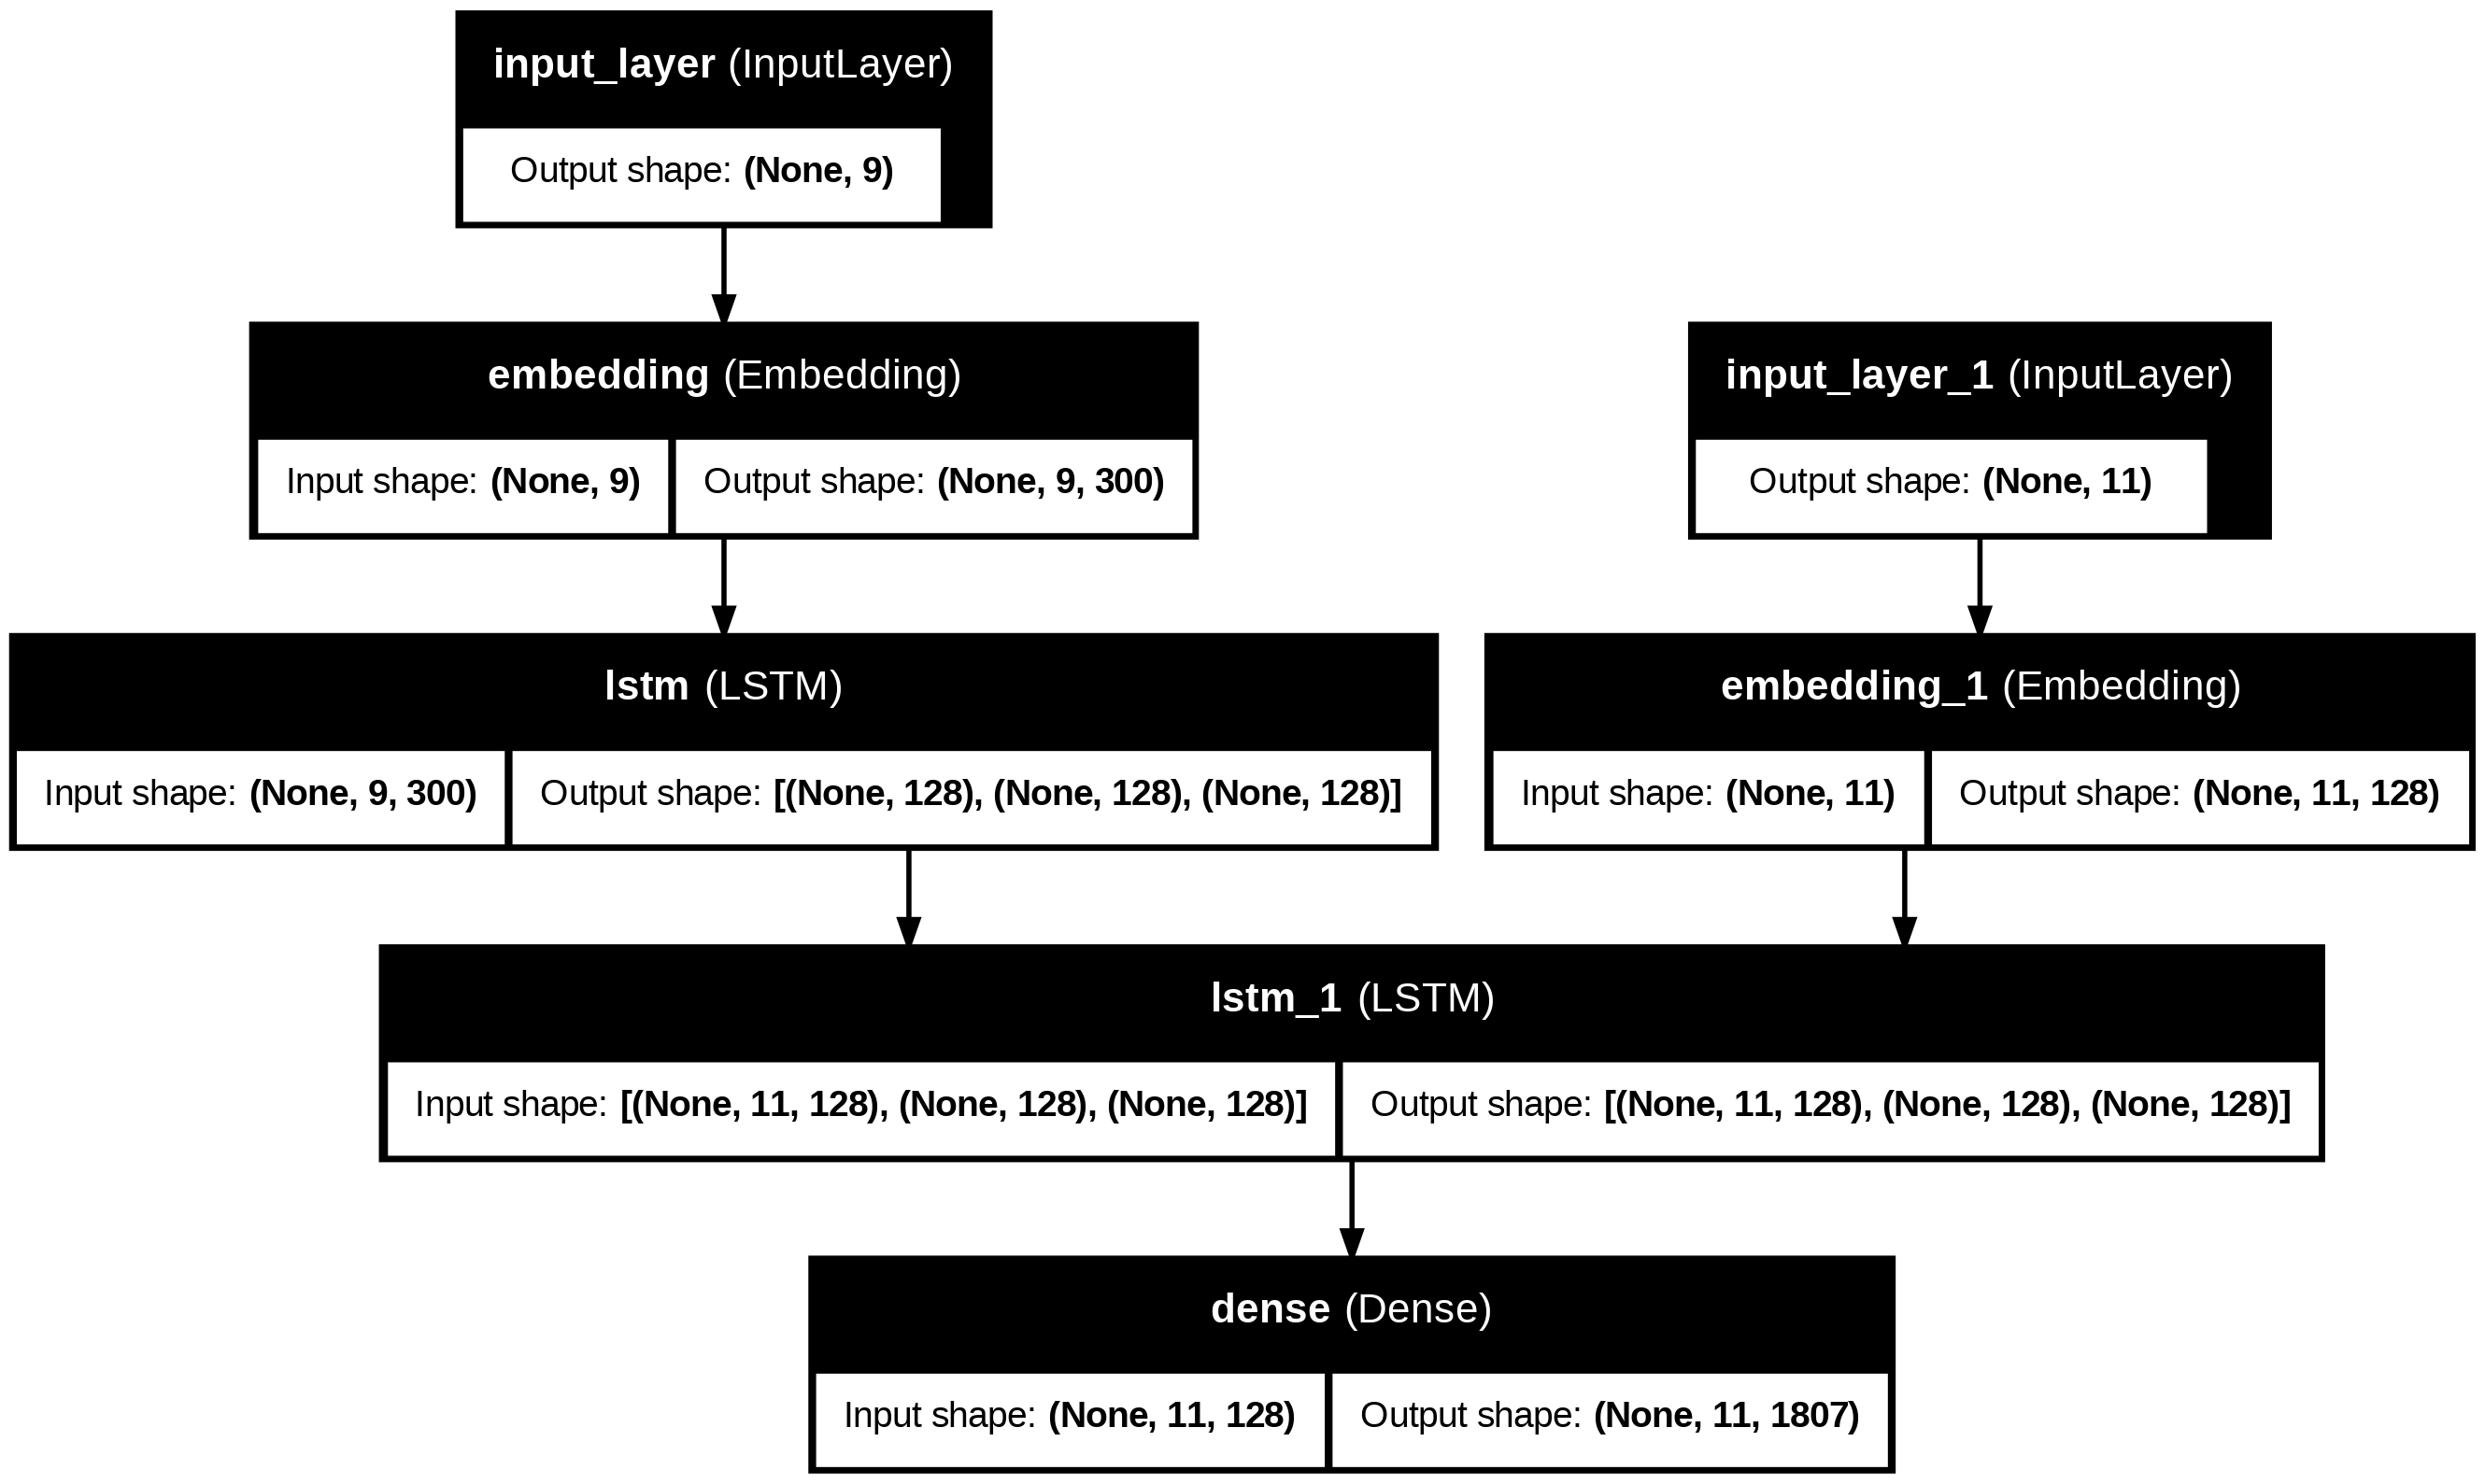

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

- **Inference encoder**

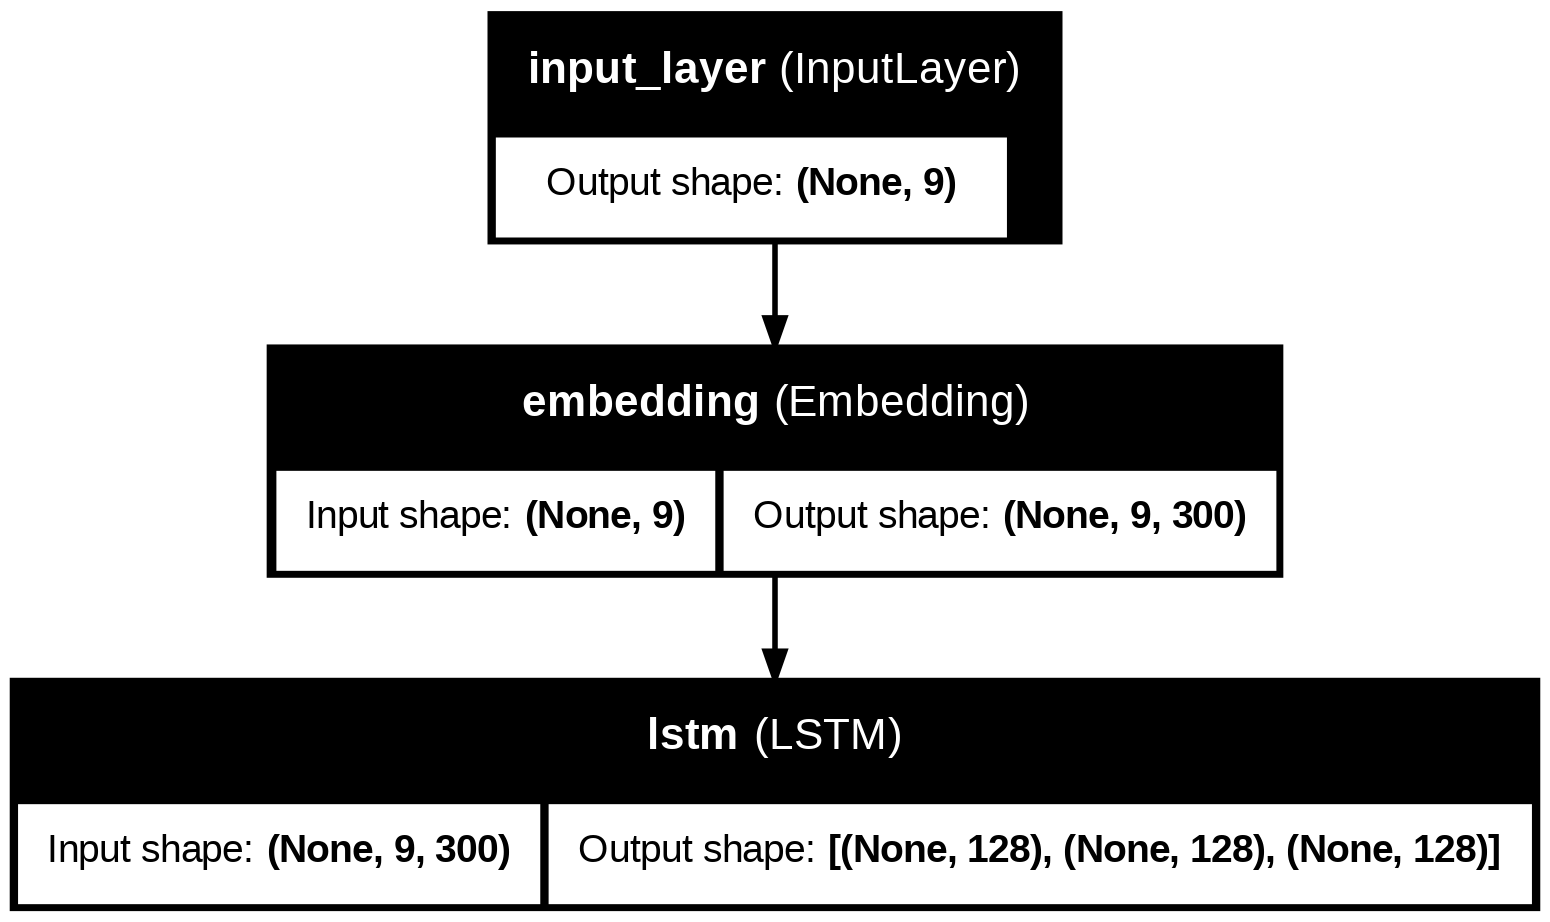

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

- **Inference decoder**

In [ ]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

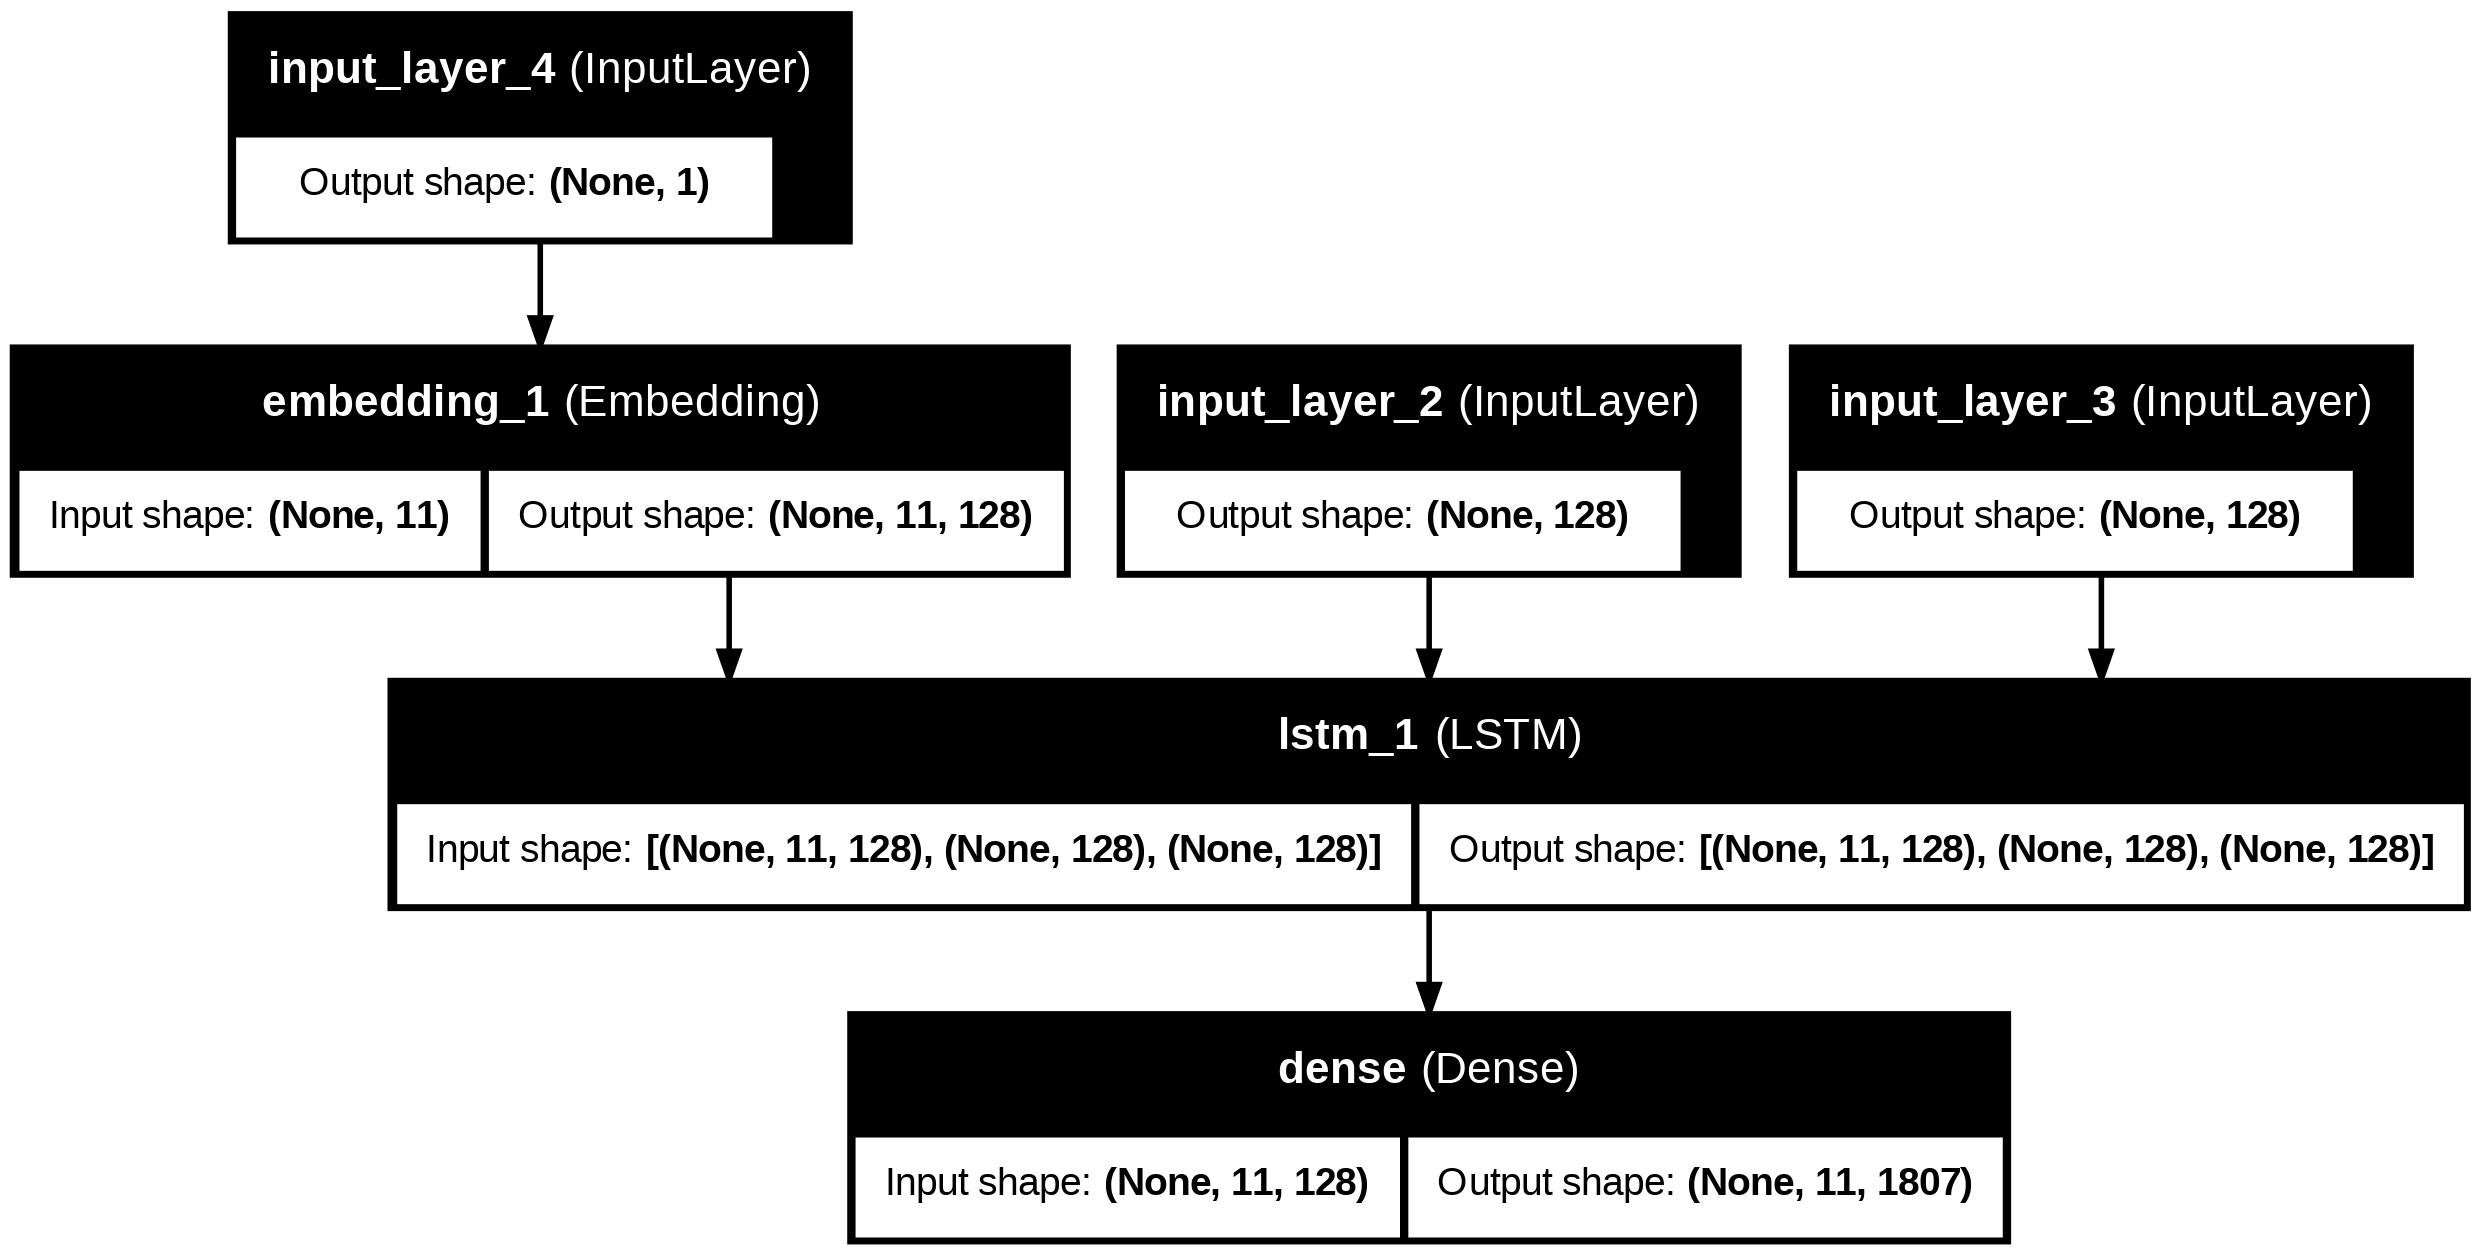

In [ ]:
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

#### Entrenamiento

In [ ]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.4835 - loss: 4.0994 - val_accuracy: 0.6655 - val_loss: 2.0670
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6506 - loss: 1.9540 - val_accuracy: 0.6883 - val_loss: 1.8992
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6982 - loss: 1.7158 - val_accuracy: 0.7170 - val_loss: 1.7529
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7305 - loss: 1.5268 - val_accuracy: 0.7252 - val_loss: 1.6742
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7435 - loss: 1.4119 - val_accuracy: 0.7301 - val_loss: 1.6218
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7539 - loss: 1.3256 - val_accuracy: 0.7373 - val_loss: 1.5878
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7620 - loss: 1.2664 - val_accuracy: 0.7405 - val_loss: 1.5566
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7625 - loss: 1.2488 - val_accu

In [ ]:
model.save('seq2seq_chatbot_model.keras')

#### Visualización

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

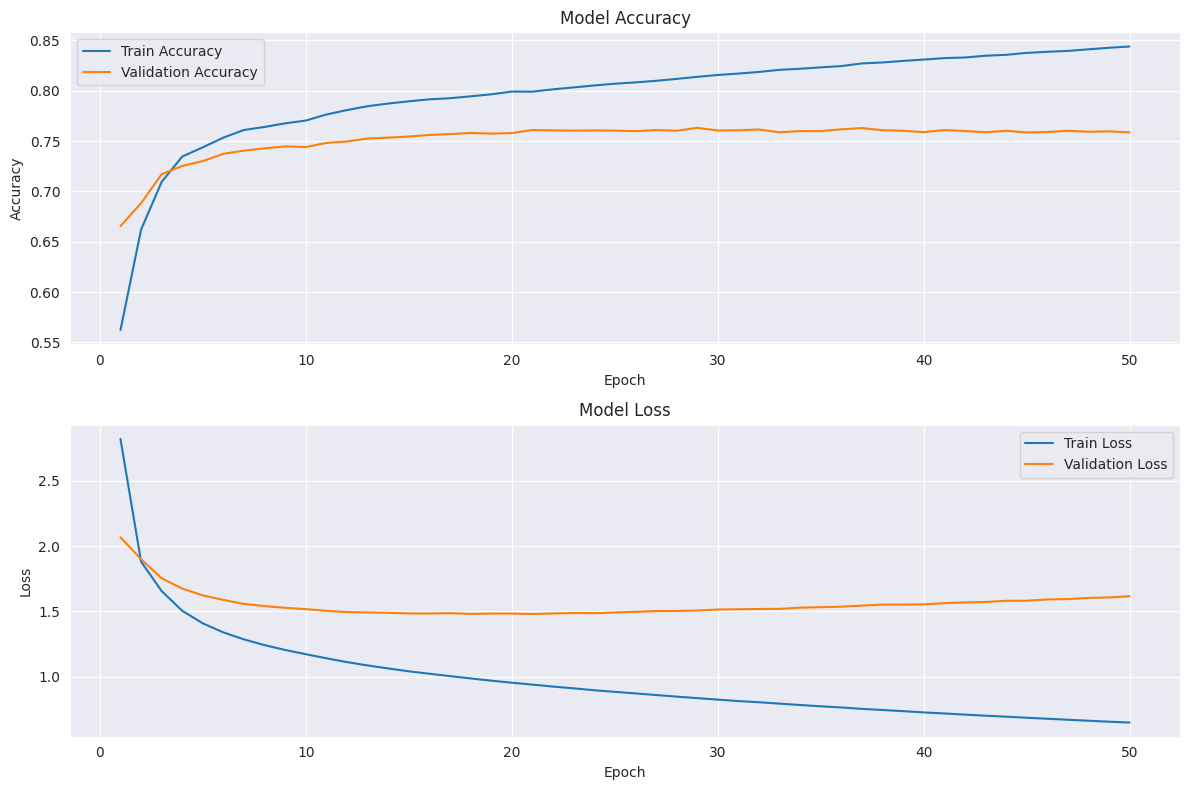

In [ ]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='Train Accuracy')
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
sns.lineplot(x=epoch_count, y=hist.history['loss'], label='Train Loss')
sns.lineplot(x=epoch_count, y=hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.savefig('acc_loss_qa.png')
plt.show()

### 5 - Inferencia


In [ ]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

#### Greedy search

In [ ]:
def qa_bot_greedy_search(input_text):
    """
    Realiza la inferencia de una frase usando el modelo seq2seq entrenado para chatbot.

    input_text: str, frase del usuario.
    return: str, respuesta generada por el chatbot.
    """
    # Preprocesar entrada: tokenizar y convertir a índices
    input_seq = [
        word2idx_inputs.get(word, word2idx_inputs.get('<unk>', 1))  # fallback <unk> o 1 si no existe
        for word in input_text.lower().split()
    ]

    # Padding de la secuencia para que tenga el largo esperado por el modelo
    input_seq = pad_sequences([input_seq], maxlen=max_input_len, padding='post')

    # Obtener el estado inicial del decoder desde el encoder
    states_value = encoder_model.predict(input_seq)

    # Inicializar secuencia del decoder con el token de inicio "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos_token_idx = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        # Obtener la predicción del próximo token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Obtener el índice del token más probable
        idx = np.argmax(output_tokens[0, 0, :])

        # Fin de la respuesta
        if idx == eos_token_idx:
            break

        # Convertir índice a palabra (solo si es válido)
        if idx > 0:
            word = idx2word_target.get(idx, '')
            if word:
                output_sentence.append(word)

        # Actualizar los estados para la siguiente predicción
        states_value = [h, c]

        # Realimentar el token predicho
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)


#### QA Greedy search

In [ ]:
input_text = "Do you read?"
response = qa_bot_greedy_search(input_text)
print("User:", input_text)
print("Bot:", response)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
User: Do you read?
Bot: i am not sure what you mean


In [ ]:
input_text = "Do you have any pet?"
response = qa_bot_greedy_search(input_text)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
User: Do you have any pet?
Bot: i like to play video games


In [ ]:
input_text = "Where are you from?"
response = qa_bot_greedy_search(input_text)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
User: Where are you from?
Bot: i m a student


#### Beam search

In [ ]:
import heapq

def qa_beam_search(input_text, beam_width=3):
    """
    Traduce una oración usando beam search con un modelo seq2seq (chatbot).

    input_text: frase del usuario
    beam_width: cuántas ramas mantener vivas en cada paso
    return: respuesta generada
    """
    # Tokenizar y preprocesar input
    input_seq = [
        word2idx_inputs.get(word, word2idx_inputs.get('<unk>', 1))
        for word in input_text.lower().split()
    ]
    input_seq = pad_sequences([input_seq], maxlen=max_input_len, padding='post')

    # Obtener estado inicial del decoder
    states_value = encoder_model.predict(input_seq)

    # Inicializar el beam: cada elemento es (log_prob, [secuencia de índices], [estado_h, estado_c])
    start_token = word2idx_outputs['<sos>']
    eos_token = word2idx_outputs['<eos>']
    beam = [(0.0, [start_token], states_value)]

    completed_sentences = []

    for _ in range(max_out_len):
        all_candidates = []

        for log_prob, seq, states in beam:
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = seq[-1]

            output_tokens, h, c = decoder_model.predict([target_seq] + states)
            output_probs = output_tokens[0, 0, :]

            # Expandir top `beam_width` predicciones
            top_indices = np.argsort(output_probs)[-beam_width:]

            for idx in top_indices:
                prob = output_probs[idx]
                new_seq = seq + [idx]
                new_log_prob = log_prob + np.log(prob + 1e-10)  # evitar log(0)
                new_states = [h, c]

                if idx == eos_token:
                    completed_sentences.append((new_log_prob, new_seq))
                else:
                    all_candidates.append((new_log_prob, new_seq, new_states))

        # Elegir los mejores `beam_width` candidatos
        beam = heapq.nlargest(beam_width, all_candidates, key=lambda tup: tup[0])

        # Si ya completamos suficientes secuencias, salimos
        if len(completed_sentences) >= beam_width:
            break

    # Elegir la mejor secuencia completada o la mejor del beam
    if completed_sentences:
        best_seq = max(completed_sentences, key=lambda tup: tup[0])[1]
    else:
        best_seq = beam[0][1]

    # Convertir a palabras
    output_sentence = [
        idx2word_target.get(idx, '') for idx in best_seq if idx not in [start_token, eos_token]
    ]

    return ' '.join(output_sentence)


#### QA Beam search

In [ ]:
input_text = "Do you read?"
response = qa_beam_search(input_text, beam_width=5)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
User: Do you read?
Bot: yes


In [ ]:
input_text = "Where are you from?"
response = qa_beam_search(input_text, beam_width=5)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
User: Where are you from?
Bot: india


In [ ]:
input_text = "Do you have any pet?"
response = qa_beam_search(input_text, beam_width=5)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
User: Do you have any pet?
Bot: no


In [ ]:
input_text = "How old are you?"
response = qa_beam_search(input_text, beam_width=5)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
User: How old are you?
Bot: good


In [ ]:
input_text = "Do you know python?"
response = qa_beam_search(input_text, beam_width=5)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
User: Do you know python?
Bot: yes


In [ ]:
input_text = "Hi"
response = qa_beam_search(input_text, beam_width=5)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
User: Hi
Bot: hi


In [ ]:
input_text = "Do you listen to rock music?"
response = qa_beam_search(input_text, beam_width=5)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
User: Do you listen to rock music?
Bot: no


In [ ]:
input_text = "Do you have friends?"
response = qa_beam_search(input_text, beam_width=5)
print("User:", input_text)
print("Bot:", response)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
User: Do you have friends?
Bot: yes


## Conclusiones

Hay una tendencia creciente del accuracy de entrenamiento, el modelo aprende y mejora su rendimiento en los datos de entrenamiento de forma constante. En validación se estabiliza temprano (~época 15), aunque sube inicialmente, después se mantiene casi plano alrededor de 0.75.

Con respecto a la loss en entrenamiento se mantiene bajando, y en validación se estabiliza y luego aumenta levemente, el modelo está sobreajustando y ya no generaliza bien a datos nuevos.

Para la inferencia del modelo se probaron con los métodos Greedy search y Beam search siendo este último el que mejor funciona en cuanto al desempeño del Chat bot, esto se ve reflejado en las secciones QA, si bien son respuestas cortas es decir sin mucho desarrollo, tienen sentido.

Para la arquitectura del modelo se consideró:

- `n_units = 128`
- `LSTM dropout = 0.2`